In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import quantities as pq
from neo.core import SpikeTrain
from elephant.spike_train_dissimilarity import van_rossum_distance
from scipy.signal import convolve2d
from tqdm import trange

In [2]:
params = {} 
params["dataset_directory"] = "/raw-spiking-heidleberg-digits-80input/"
params["verbose"] = False

In [3]:
# load dataset
x_train = np.load("/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/raw-spiking-heidleberg-digits-80input/training_x_spikes.npy", allow_pickle = True)
y_train = np.load("/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/raw-spiking-heidleberg-digits-80input/training_y_spikes.npy", allow_pickle = True)

training_details = pd.read_csv(os.getcwd() + params.get("dataset_directory") + "training_details.csv")
testing_details = pd.read_csv(os.getcwd() + params.get("dataset_directory") + "testing_details.csv")


In [4]:
if params["verbose"]: print(training_details.head())
speaker_id = np.sort(training_details.Speaker.unique())
speaker_id = speaker_id = speaker_id.astype('int8')  #np where is fussy with int
if params["verbose"]: print(np.sort(testing_details.Speaker.unique()))
list_of_speaker = np.array(list(training_details.loc[:, "Speaker"]))

In [5]:
speaker_x_indexes_list = [[] for _ in range(20)]

speaker_x_digit_x_indexes_list = [[] for _ in range(20)]

for d in np.unique(y_train):
    speaker_x_digit_y_indexes_list = [[] for _ in range(20)]
    for s in speaker_id:
        speaker_x_indexes_list[s] = np.where(np.array(list_of_speaker) == s)[0]
        speaker_x_digit_y_indexes_list[s] = np.where(np.array(y_train[speaker_x_indexes_list[s]]) == d)[0]
    speaker_x_digit_x_indexes_list[d] = speaker_x_digit_y_indexes_list

In [6]:
def get_average_digit(speaker_x_indexes_list,
                      speaker_x_digit_x_indexes_list,
                      digit,
                      speaker,
                      y_data,
                      x_data,
                      unique_speakers):
    """Creates an "average" image for a desired speaker and digit

    Args:
        speaker_x_indexes_list (list): list of speaker indexes for speaker x [speaker]
        speaker_x_digit_x_indexes_list (list): list of digits for speaker x [digit][speaker]
        digit (int): desired digit to be averaged
        speaker (int): desired speaker of digit to be averaged

    """
    # confirm speaker is in dataset
    assert speaker in unique_speakers

    # confirming the correct data is being loaded for digit x
    assert np.unique(y_data[speaker_x_indexes_list[speaker]][speaker_x_digit_x_indexes_list[digit][speaker]])[0] == digit

    number_of_digit = len(y_data[speaker_x_indexes_list[speaker]][speaker_x_digit_x_indexes_list[digit][speaker]])

    average_digit = []
    for d in range(number_of_digit):
        average_digit.append(x_data[speaker_x_indexes_list[speaker]][speaker_x_digit_x_indexes_list[digit][speaker]][d][d::number_of_digit])
    
    result = np.concatenate(average_digit, dtype=[('x', 'i1'), ('t', '<i2'), ('p', 'i1')])
    
    return np.sort(result, order = 't')
    

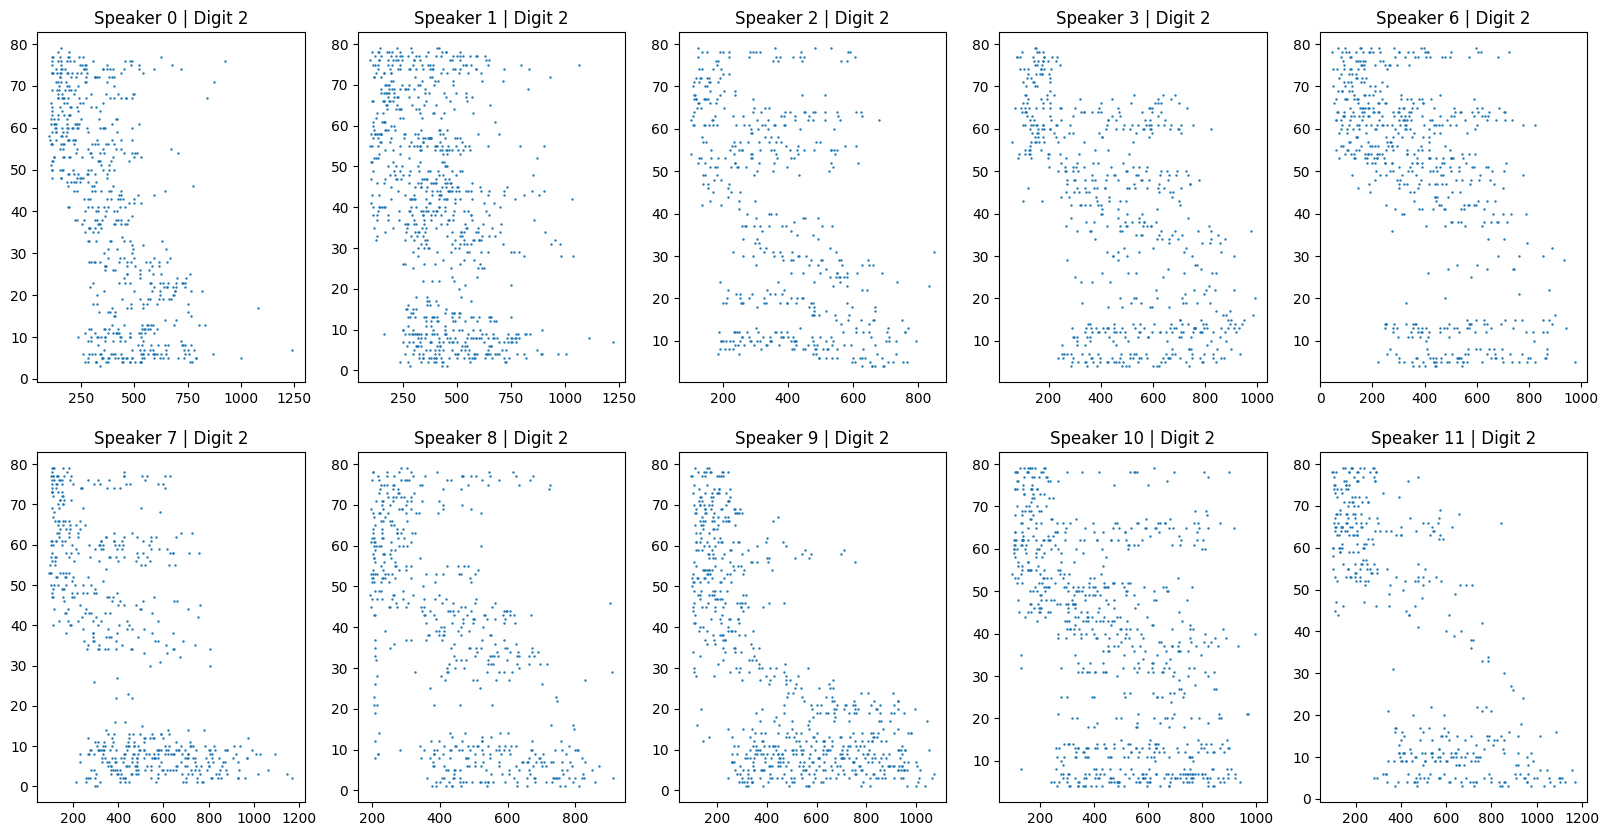

In [7]:
# speakers for digit 2

plt.figure(figsize=(20, 10), dpi=100)

count = 0

for display_speaker in speaker_id:
    count += 1
    
    plt.subplot(2, 5, count)
    
    averaged_digit = get_average_digit(speaker_x_indexes_list, 
                                       speaker_x_digit_x_indexes_list, 
                                       2, 
                                       display_speaker, 
                                       y_train, 
                                       x_train, 
                                       np.sort(training_details.Speaker.unique()))
    
    plt.scatter(averaged_digit['t'],
                averaged_digit['x'],
                s = 0.5)
    
    plt.title(f"Speaker {display_speaker} | Digit 2")

plt.show()    
    

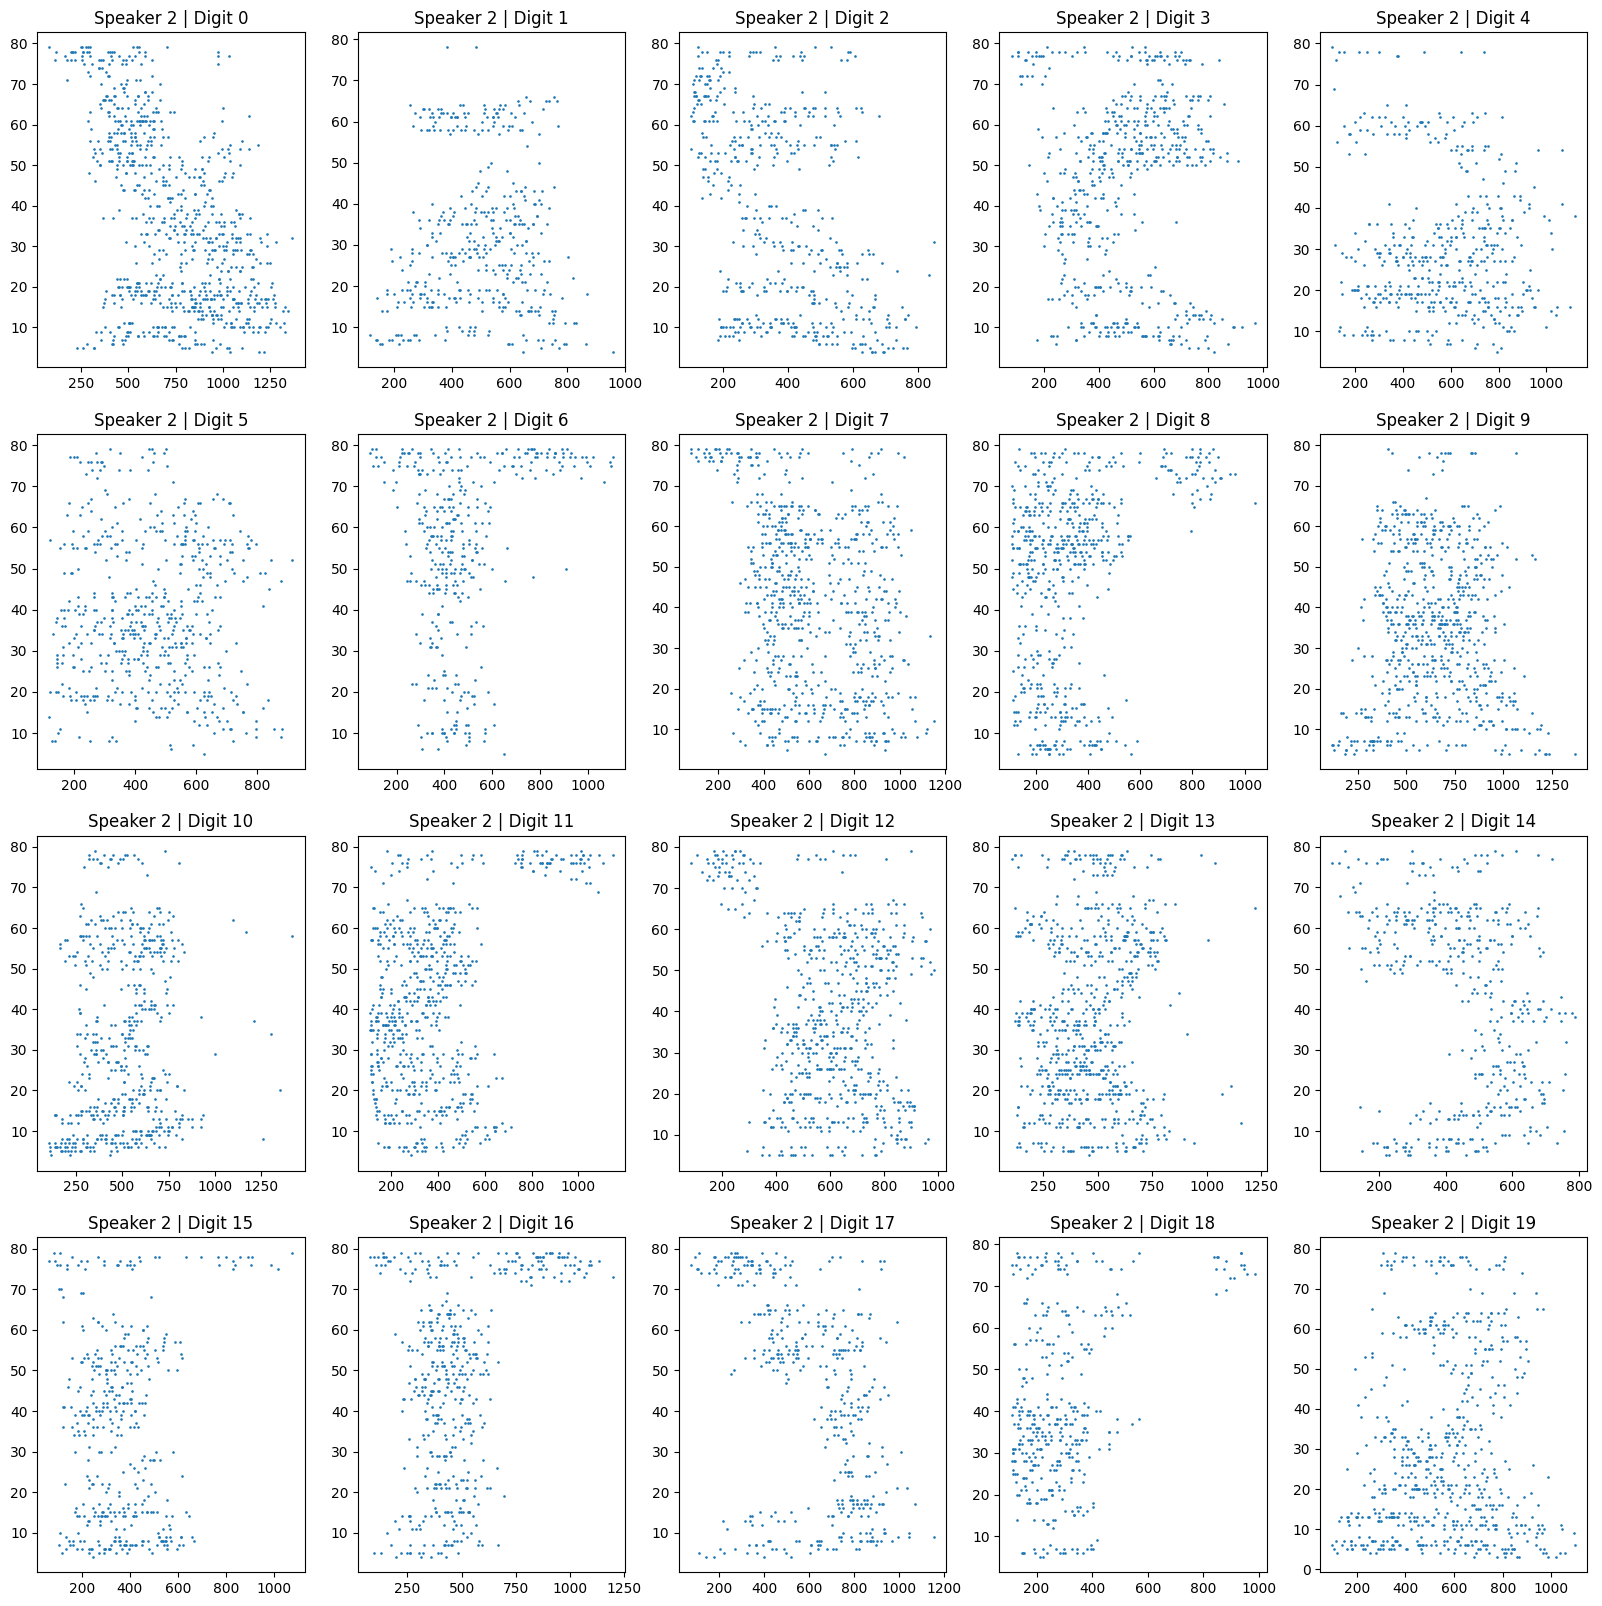

In [8]:
# digits for speaker 2

plt.figure(figsize=(20, 20), dpi=100)

count = 0

for display_digit in np.unique(y_train):
    count += 1
    
    plt.subplot(4, 5, count)
    
    averaged_digit = get_average_digit(speaker_x_indexes_list, 
                                       speaker_x_digit_x_indexes_list, 
                                       display_digit, 
                                       2, 
                                       y_train, 
                                       x_train, 
                                       np.sort(training_details.Speaker.unique()))
    
    plt.scatter(averaged_digit['t'],
                averaged_digit['x'],
                s = 0.8)
    
    plt.title(f"Speaker 2 | Digit {display_digit}")

plt.show()    
    

In [12]:
def exponential_kernel_2d(size_t, size_x, tau_t, tau_x):
    t = np.linspace(-size_t/2, size_t/2, size_t + 1, dtype='int8')
    x = np.linspace(-size_x/2, size_x/2, size_x + 1, dtype = 'int8')
    
    T, X = np.meshgrid(t, x, indexing='ij')
    
    kernel = np.exp(-np.abs(T) / tau_t) * np.exp(-np.abs(X) / tau_x)
    
    # 3D Surface plot
    fig = plt.figure(figsize=(12, 5))
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot_surface(T, X, kernel, cmap='viridis', edgecolor='none')
    ax2.set_title("3D Surface Plot of Kernel")

    plt.show() 
    
    return kernel / np.sum(kernel)  # Normalize kernel

def gaussian_kernel_2d(size_t, size_x, sigma_t = 10, sigma_x = 10, display = False):

    t = np.arange(-size_t // 2, size_t // 2 + 1)
    x = np.arange(-size_x // 2, size_x // 2 + 1)

    T, X = np.meshgrid(t, x, indexing='ij')

    kernel = np.exp(-((T**2) / (2 * sigma_t**2) + (X**2) / (2 * sigma_x**2)))
    kernel /= np.sum(kernel)

    if display:
        # Plot kernel
        fig = plt.figure(figsize=(6, 5))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(T, X, kernel, cmap='viridis', edgecolor='none')
        ax.set_title("3D Surface Plot of Gaussian Kernel")
        
        plt.show()
    
    return kernel

def get_vr_distance_2d(spike_train1, 
                       spike_train2, 
                       tau_t = 40, 
                       tau_x = 5,
                       size_t = 40,
                       size_x = 10, 
                       last_spike_t = 1600, 
                       num_neurons = 80,
                       display = False):
    
    time_bins = np.arange(0, last_spike_t + 1, 1)  # 1 ms bins
    spike_matrix1 = np.zeros((len(time_bins), num_neurons))
    spike_matrix2 = np.zeros((len(time_bins), num_neurons))

    for t, x in zip(spike_train1['t'], spike_train1['x']):
        spike_matrix1[int(t), int(x)] = 1
    for t, x in zip(spike_train2['t'], spike_train2['x']):
        spike_matrix2[int(t), int(x)] = 1
    
    #kernel = exponential_kernel_2d(size_t = size_t, size_x = size_x, tau_t=tau_t, tau_x=tau_x)
    kernel = gaussian_kernel_2d(size_t = size_t, size_x = size_x, sigma_x = tau_x, sigma_t = tau_t, display = display)
    
    smoothed1 = convolve2d(spike_matrix1, kernel, mode='same', boundary='wrap')
    smoothed2 = convolve2d(spike_matrix2, kernel, mode='same', boundary='wrap')
    
    # Compute Euclidean distance between smoothed spike matrices
    distance = np.linalg.norm(smoothed1 - smoothed2)
    
    return distance, smoothed1, kernel

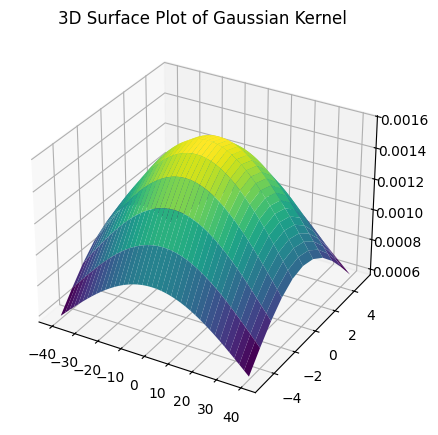

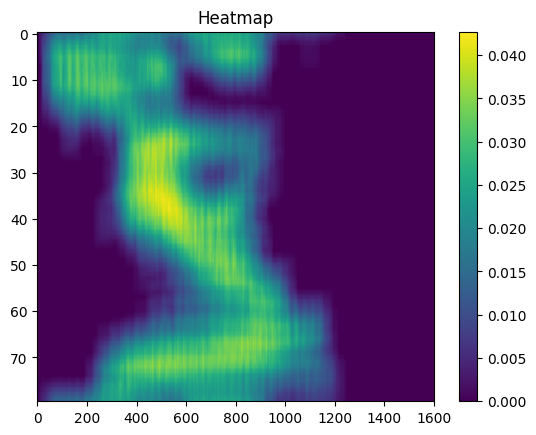

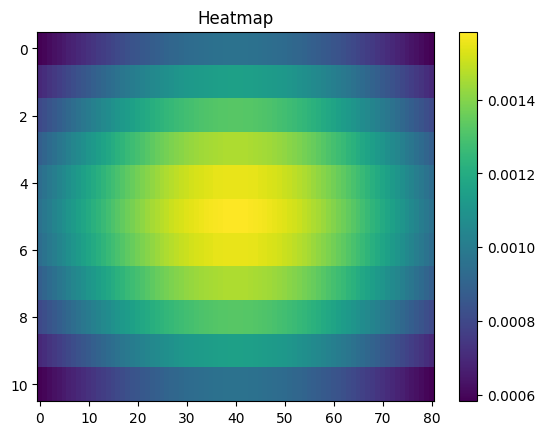

In [13]:
s = 1
d = 0


distance, smoothed1, kernel = get_vr_distance_2d(x_train[speaker_x_indexes_list[s]][speaker_x_digit_x_indexes_list[d][s]][0],
                                                 x_train[speaker_x_indexes_list[s]][speaker_x_digit_x_indexes_list[d][s]][1],
                                                 display = True,
                                                 size_t = 80)

plt.imshow(np.flip(np.swapaxes(smoothed1, 1, 0), 0), aspect = 'auto')
plt.colorbar()
plt.title('Heatmap')
plt.show()

plt.imshow(np.flip(np.swapaxes(kernel, 1, 0), 0), aspect = 'auto')
plt.colorbar()
plt.title('Heatmap')
plt.show()

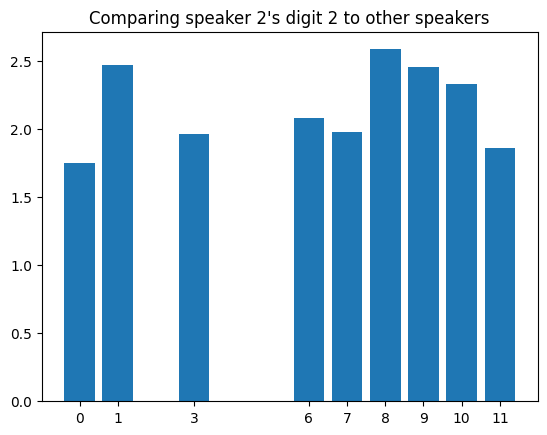

In [11]:
# comparing speaker 2's digit 2 to every other speaker's digit 2

starting_speaker = 2
starting_digit = 2

starting_averaged_digit = get_average_digit(speaker_x_indexes_list, 
                                            speaker_x_digit_x_indexes_list, 
                                            starting_digit, 
                                            starting_speaker, 
                                            y_train, 
                                            x_train, 
                                            np.sort(training_details.Speaker.unique()))

distance_across_speakers = []
speakers_compared = []

for comparing_speaker in np.unique(list_of_speaker):
    if comparing_speaker == starting_speaker: continue
    
    comparing_averaged_digit = get_average_digit(speaker_x_indexes_list, 
                                                 speaker_x_digit_x_indexes_list, 
                                                 starting_digit, 
                                                 comparing_speaker, 
                                                 y_train, 
                                                 x_train, 
                                                 np.sort(training_details.Speaker.unique()))

    
    

    distance, S, _ = get_vr_distance_2d(starting_averaged_digit,
                                        comparing_averaged_digit,
                                        display = False,
                                        size_t = 80)
    
    if False:
        plt.imshow(np.flip(np.swapaxes(S, 1, 0), 0), aspect = 'auto')
        plt.colorbar()
        plt.title('Heatmap')
        plt.show()
        print(comparing_speaker, distance)
        
    distance_across_speakers.append(distance)
    speakers_compared.append(comparing_speaker)
    
    
plt.title(f"Comparing speaker {starting_speaker}'s digit {starting_digit} to other speakers")
plt.bar(speakers_compared, distance_across_speakers)
plt.xticks(speakers_compared)
plt.show() 

In [12]:
# comparing speaker 2's digit 2 to every other speaker's digit 2
count = 0
across_digits = []
for starting_digit in np.unique(y_train):
    across_speakers = []
    for starting_speaker in np.sort(training_details.Speaker.unique()):

        print(count, 20*10)
        count += 1

        starting_averaged_digit = get_average_digit(speaker_x_indexes_list, 
                                                    speaker_x_digit_x_indexes_list, 
                                                    starting_digit, 
                                                    starting_speaker, 
                                                    y_train, 
                                                    x_train, 
                                                    np.sort(training_details.Speaker.unique()))

        distance_across_speakers = []
        speakers_compared = []

        for comparing_speaker in np.unique(list_of_speaker):
            if comparing_speaker == starting_speaker: continue
            
            comparing_averaged_digit = get_average_digit(speaker_x_indexes_list, 
                                                        speaker_x_digit_x_indexes_list, 
                                                        starting_digit, 
                                                        comparing_speaker, 
                                                        y_train, 
                                                        x_train, 
                                                        np.sort(training_details.Speaker.unique()))

            
            

            distance, S, _ = get_vr_distance_2d(starting_averaged_digit,
                                                comparing_averaged_digit,
                                                display = False,
                                                size_t = 80)
            
            if False:
                plt.imshow(np.flip(np.swapaxes(S, 1, 0), 0), aspect = 'auto')
                plt.colorbar()
                plt.title('Heatmap')
                plt.show()
                print(comparing_speaker, distance)
                
            distance_across_speakers.append(distance)
            speakers_compared.append(comparing_speaker)
        
        across_speakers.append((speakers_compared, distance_across_speakers))
    across_digits.append(across_speakers)

0 200
1 200
2 200
3 200
4 200
5 200
6 200
7 200
8 200
9 200
10 200
11 200
12 200
13 200
14 200
15 200
16 200
17 200
18 200
19 200
20 200
21 200
22 200
23 200
24 200
25 200
26 200
27 200
28 200
29 200
30 200
31 200
32 200
33 200
34 200
35 200
36 200
37 200
38 200
39 200
40 200
41 200
42 200
43 200
44 200
45 200
46 200
47 200
48 200
49 200
50 200
51 200
52 200
53 200
54 200
55 200
56 200
57 200
58 200
59 200
60 200
61 200
62 200
63 200
64 200
65 200
66 200
67 200
68 200
69 200
70 200
71 200
72 200
73 200
74 200
75 200
76 200
77 200
78 200
79 200
80 200
81 200
82 200
83 200
84 200
85 200
86 200
87 200
88 200
89 200
90 200
91 200
92 200
93 200
94 200
95 200
96 200
97 200
98 200
99 200
100 200
101 200
102 200
103 200
104 200
105 200
106 200
107 200
108 200
109 200
110 200
111 200
112 200
113 200
114 200
115 200
116 200
117 200
118 200
119 200
120 200
121 200
122 200
123 200
124 200
125 200
126 200
127 200
128 200
129 200
130 200
131 200
132 200
133 200
134 200
135 200
136 200
137 200
138 20

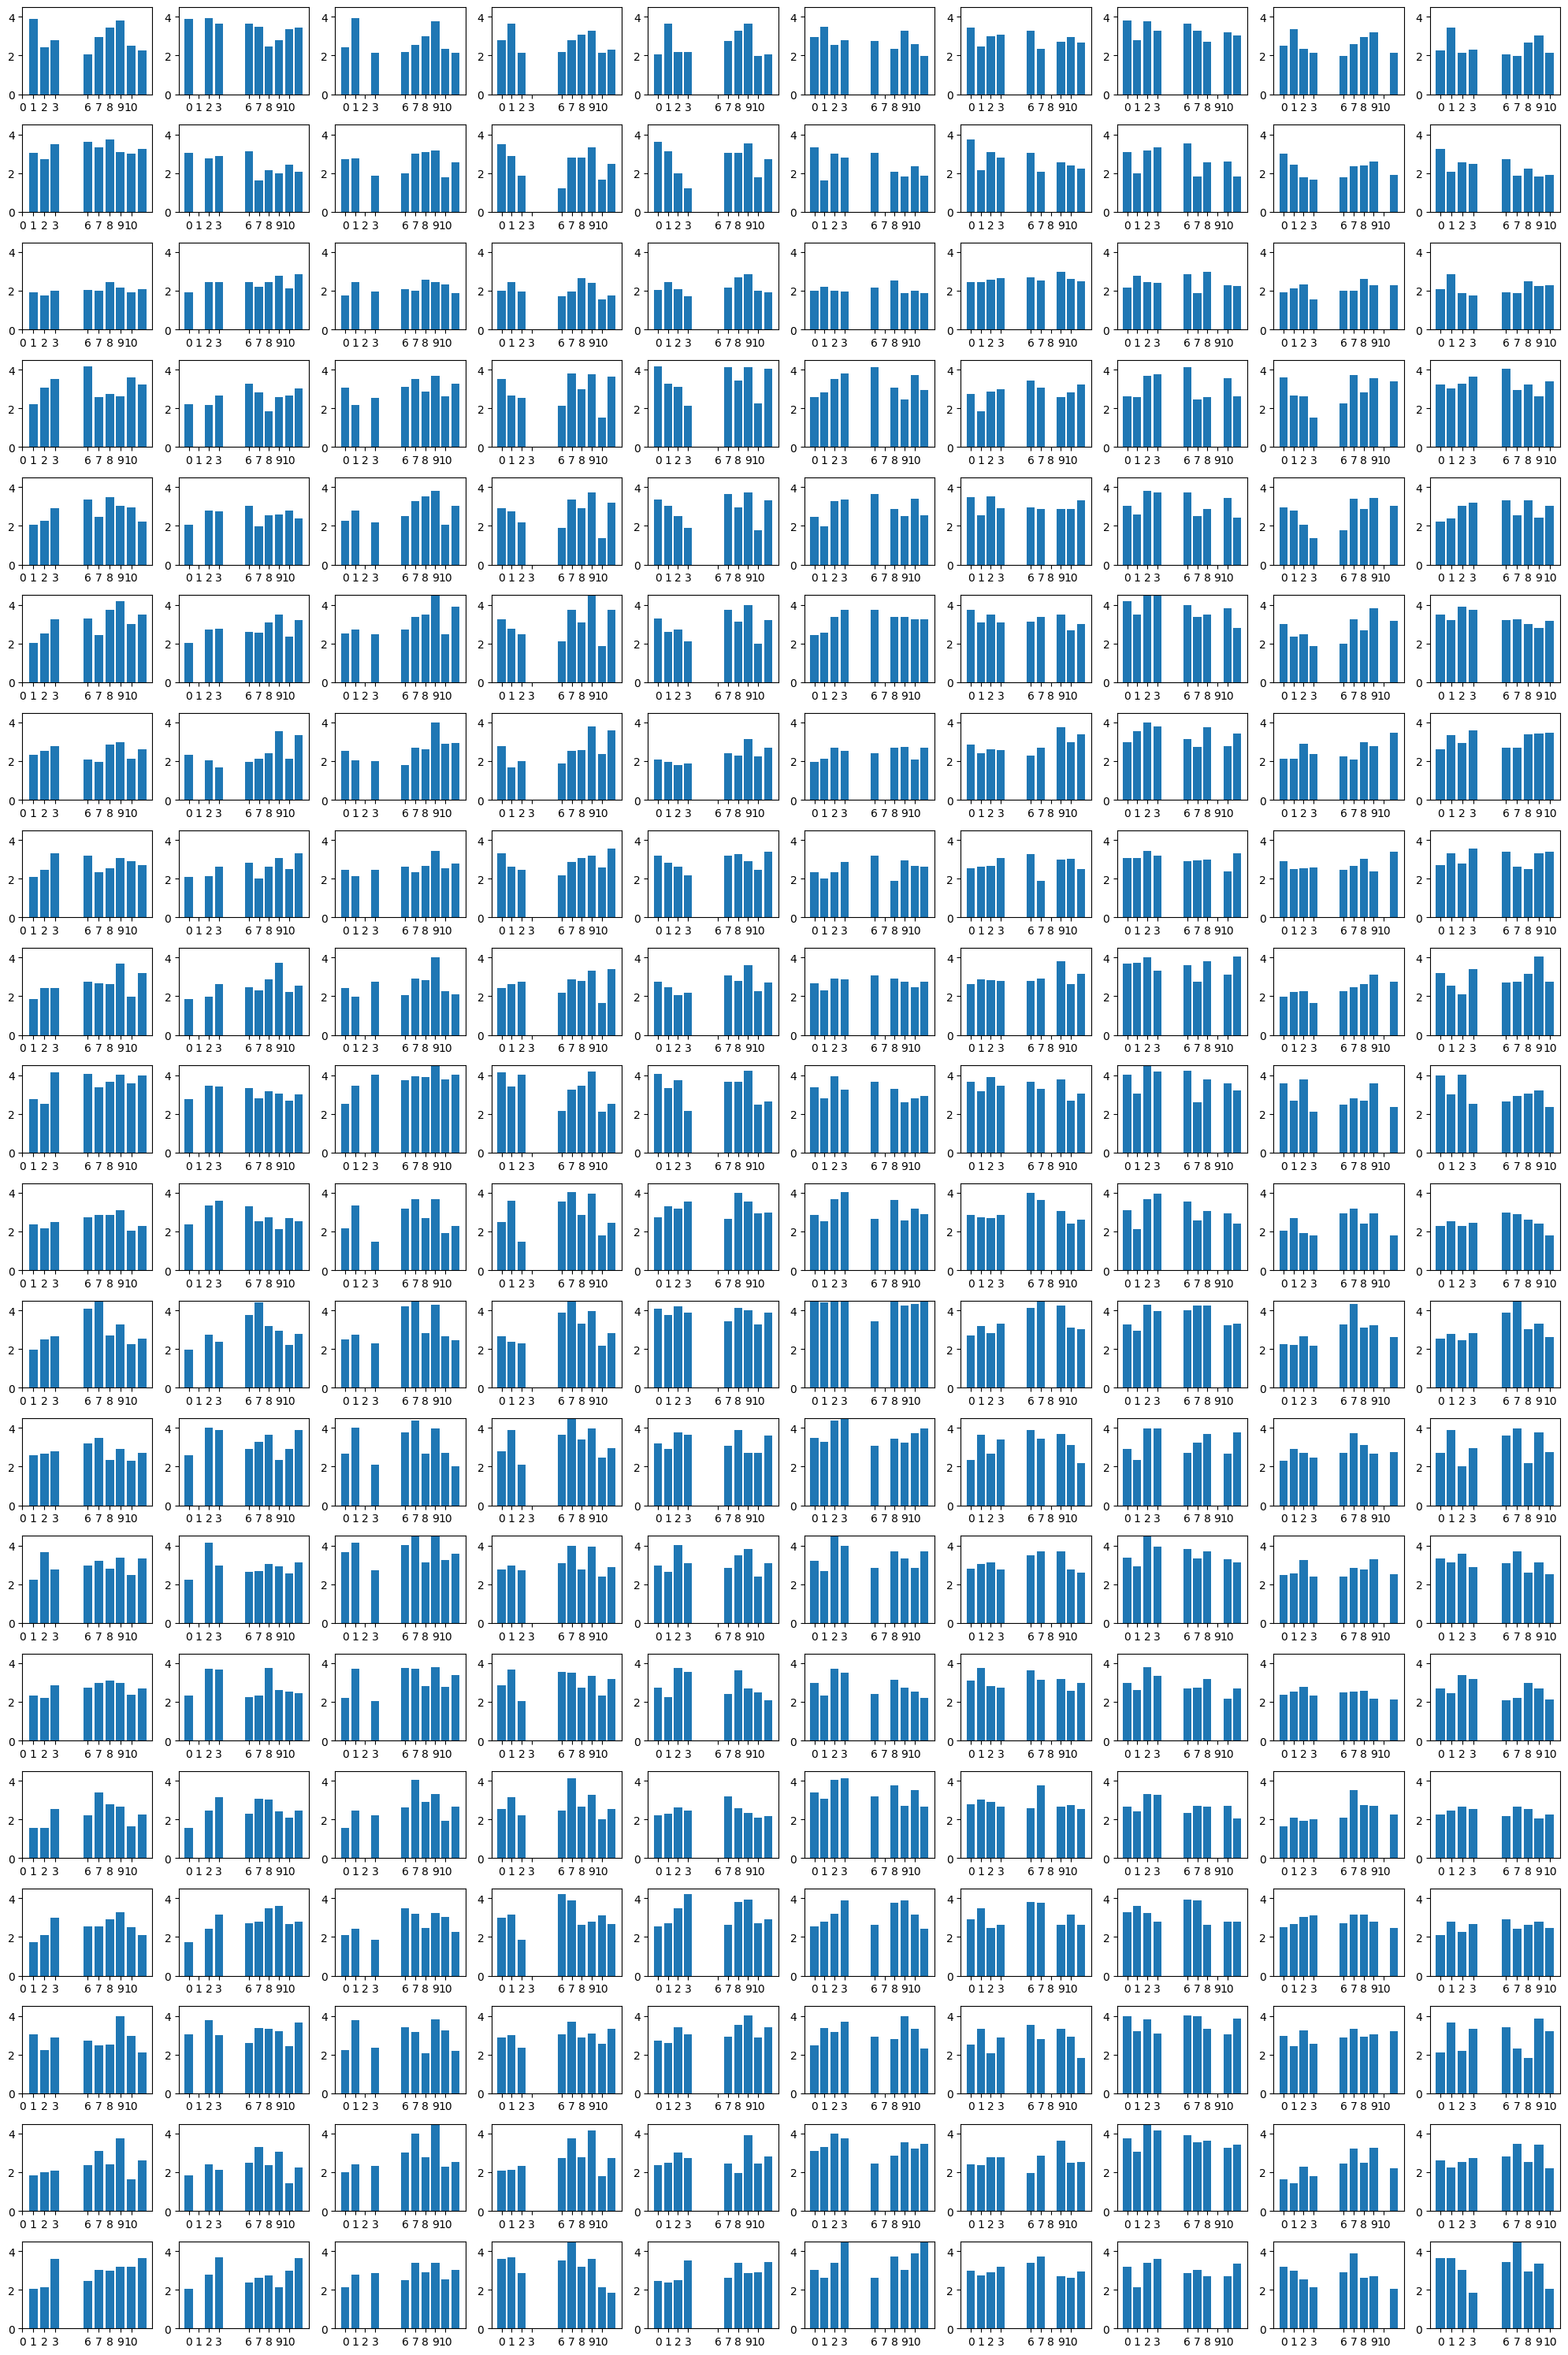

In [13]:
plt.figure(figsize=(20, 30), dpi=100)

count = 0
for digits in range(20):
    for speakers in range(10):
        count += 1
        plt.subplot(len(np.unique(y_train)), len(np.sort(training_details.Speaker.unique())), count)
            
        #plt.title(f"Comparing speaker {starting_speaker}'s digit {starting_digit} to other speakers")
        plt.bar(across_digits[digits][speakers][0], across_digits[digits][speakers][1])
        plt.xticks(speakers_compared)

        plt.ylim(0, 4.5)
plt.tight_layout()
plt.show() 

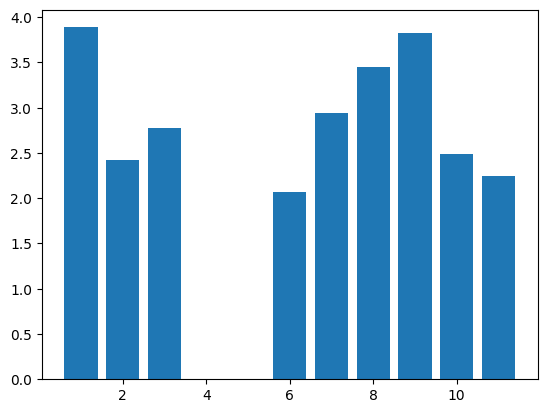

In [14]:
plt.bar(across_digits[0][0][0], across_digits[0][0][1])
plt.show()

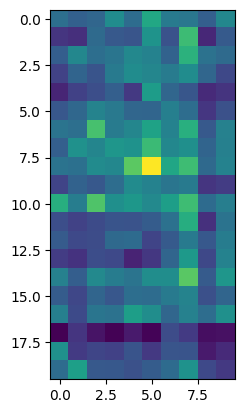

In [15]:
average_heatmap = np.zeros((10, 20))

for d in range(20):
    for s in range(10):
        average_heatmap[s, d] = sum(across_digits[d][s][1]) / len(across_digits[d][s][1])
        
plt.imshow(np.rot90(average_heatmap))
plt.show()

In [20]:
np.save("difference_across_digits.npy", across_digits)